C:\Users\Sami\AppData\Local\Temp\ipykernel_3412\1573180623.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  densityPlot.set_yticklabels('{:,.0%}'.format(y) for y in ylabels)


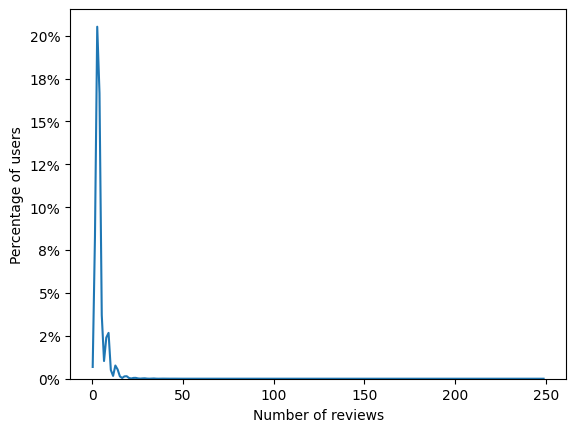

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read data into a DataFrame
df = pd.read_csv('ratings.csv', dtype={"vote": str})

counts = df.groupby('reviewerID')['reviewerID'].size()

densityPlot = sns.kdeplot(counts)
ylabels = densityPlot.get_yticks()
densityPlot.set_yticklabels('{:,.0%}'.format(y) for y in ylabels)
plt.xlabel("Number of reviews")
plt.ylabel("Percentage of users")
plt.show()
plt.savefig()